# Bayes and Naive Bayes from Scratch

Let us first import the necessary libraries and define the dataframe shuffle utility

In [1]:
from typing import List

import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from openml.datasets import get_dataset
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


def shuffle_df(df: pd.DataFrame):
    return df.sample(frac=1, random_state=0).reset_index(drop=True)

We use Kernel Density Estimation to approximate the required PDFs
- we will work with continuous data in this example
- `fit_kde` fits and returns scikit-learn's `KernelDensity` class
- see `https://mathisonian.github.io/kde/` for a nice visualization

In [2]:
def fit_kde(data: pd.DataFrame):
    density_estimator = KernelDensity()
    density_estimator.fit(data)
    return density_estimator

- `get_prior_probs` computes prior probabilities for each class in the provided data

In [3]:
def get_prior_probs(data: pd.DataFrame):
    data.sort_values(by="class")
    probs = [
        len(grouped_df) / len(data) 
        for c_j, grouped_df in data.groupby("class")
    ]
    return np.array(probs)

## Bayes Estimator
1. compute prior probabilites from training data
2. fit kernel density estimators to aproximate p(o|c_j) 
    - one estimator for each class
3. compute p(o|c_j)p(c_j) and select the maximum

In [4]:
class Bayes:
    def __init__(self):
        self.KDEs: List[KernelDensity] = None  # List of Kernel density estimators, one for each class
        self.prior_probs: np.ndarray = None

    def fit(self, data: pd.DataFrame):
        data.sort_values(by="class")
        self.KDEs = [fit_kde(class_data.drop("class", axis=1))  # fit one estimator for each class
                     for _, class_data in data.groupby("class")]  # group data by class and iterate over those groups
        self.prior_probs = get_prior_probs(data)

    def predict(self, samples: pd.DataFrame):
        proba = self.predict_proba(samples)
        return np.argmax(proba, axis=0)
    
    def predict_proba(self, samples: pd.DataFrame):
        if "class" in samples.columns:  # remove class column from samples if necessary
            samples = samples.drop("class", axis=1)  
        likelihoods = self._compute_likelihoods(samples)
        # self.prior_probs has shape (n_classes) so we need to add an extra dimension to get shape (n_classes, 1)
        # numpy can then broadcast the result to the shape of `likelihoods` (which should be (n_classes, n_samples))
        proba = np.expand_dims(self.prior_probs, axis=-1) * likelihoods
        return proba

    def _compute_likelihoods(self, samples: pd.DataFrame):
        log_likelihoods = [kde.score_samples(samples) for kde in self.KDEs]
        return np.exp(log_likelihoods)

## Naive Bayes

Similar to before, but we will have one Kernel Density Estimator for each dimension of the data.
- to get the joint probability we can then just take the product of their estimates (independence assumption)

Let us define two utility functions for evaluating the kernel density estimators
- `get_naive_marginal_density_estimators` gives us a list of KDEs, one for each row in the data
- `evaluate_kde_rowwise` computes the probability densities for each estimator in each row
    - the result has shape (n_samples, n_dimensions)

In [5]:
def get_naive_marginal_density_estimators(data: pd.DataFrame):
    kde_estimators = []
    for col in data:
        data_in_col = data[col].to_numpy()
        data_in_col = np.expand_dims(data_in_col, axis=-1)
        estimator = KernelDensity().fit(data_in_col)
        kde_estimators.append(estimator)
    return kde_estimators


def evaluate_kde_rowwise(samples: pd.DataFrame, estimators: List[KernelDensity]):
    assert len(samples.columns) == len(estimators)
    likelihoods = []
    for col_index, col in enumerate(samples.columns):
        data_in_col = samples[col].to_numpy()
        data_in_col = np.expand_dims(data_in_col, axis=-1)
        log_likelihood = estimators[col_index].score_samples(data_in_col)
        likelihood = np.exp(log_likelihood)
        likelihoods.append(likelihood)
    return np.array(likelihoods).T

We can now adapt Bayes to be "naive":

In [6]:
class NaiveBayes:
    def __init__(self, additive_smooting=0.0):
        self.KDEs: List[List[KernelDensity]] = None  # class -> dimension -> estimator
        self.prior_probs: np.ndarray = None
        self.additive_smoothing = additive_smooting  # the constant we add to avoid zero probabilities

    def fit(self, data: pd.DataFrame):
        data.sort_values(by="class")
        self.KDEs = [get_naive_marginal_density_estimators(class_data.drop("class", axis=1))  # one estimator per dimension
                     for _, class_data in data.groupby("class")]
        self.prior_probs = get_prior_probs(data)

    def predict(self, samples: pd.DataFrame):
        proba = self.predict_proba(samples)
        return np.argmax(proba, axis=0)
    
    def predict_proba(self, samples: pd.DataFrame):
        if "class" in samples.columns:
            samples = samples.drop("class", axis=1)
        likelihoods = self._compute_likelihoods(samples)
        products = np.expand_dims(self.prior_probs, axis=-1) * likelihoods
        return products

    def _compute_likelihoods(self, samples: pd.DataFrame):
        likelihoods = [
            evaluate_kde_rowwise(samples, class_kde_estimators)
            for class_kde_estimators in self.KDEs
        ]
        likelihoods = np.array(likelihoods)
        likelihoods += self.additive_smoothing  # Laplace smoothing
        likelihoods = np.prod(likelihoods, axis=-1)  # here we apply the "naive" independence assumption
        return likelihoods

## Evaluation (binary classification)

We will use the Wisconsin Breast Cancer Dataset (https://www.openml.org/search?type=data&status=active&id=43611). Our goal is to classify if an observation indicates cancer or not. The dataset has the following features:
- Clump Thickness: 1 - 10
- Uniformity of Cell Size: 1 - 10 
- Uniformity of Cell Shape: 1 - 10 
- Marginal Adhesion: 1 - 10 
- Single Epithelial Cell Size: 1 - 10 
- Bare Nuclei: 1 - 10 
- Bland Chromatin: 1 - 10 
- Normal Nucleoli: 1 - 10 
- Mitoses: 1 - 10
- Class: benign or malignant

Data loading and preprocessing:

In [7]:
BREAST_CANCER = 43611
data = get_dataset(BREAST_CANCER).get_data()[0]
data.dropna(axis=0, inplace=True)
if "id" in data.columns:
    data = data.drop("id", axis=1)
data = shuffle_df(data)
data.rename({"Class": "class"}, axis=1, inplace=True)
data["class"] = LabelEncoder().fit_transform(data["class"])

Could not download file from http://openml1.win.tue.nl/dataset43611/dataset_43611.pq: Bucket does not exist or is private.


Let's see if the data is balanced or imbalanced:

In [8]:
get_prior_probs(data) 

array([0.65007321, 0.34992679])

Split into test and train

In [9]:
num_train = int(0.7 * len(data))
train, test = data.loc[:num_train], data.loc[num_train:]

Create the algorithms we want to compare

In [10]:
bayes = Bayes()
naive_bayes = NaiveBayes()
naive_bayes_with_smoothing = NaiveBayes(additive_smooting=0.01)
algorithms = {"Bayes": bayes, "Naive Bayes": naive_bayes, "Naive Bayes (smoothed)": naive_bayes_with_smoothing}

Fit each algorithm

In [11]:
for algorithm in algorithms.values():
    algorithm.fit(train)

Evaluate each algorithm on train and test data

In [12]:
eval_datasets = {"Training data": train, "Test data": test}
result_df = []
for ds_name, eval_data in eval_datasets.items():
    for alg_name, alg in algorithms.items():
        majority_vote_agreement = np.sum(test["class"])
        if majority_vote_agreement < 0.5 * len(eval_data):
            majority_vote_agreement = len(eval_data) - majority_vote_agreement
        predictions = alg.predict(samples=eval_data)
        correct_predictions = predictions == eval_data["class"]
        num_correct = np.sum(correct_predictions)
        accuracy = num_correct / len(eval_data)
        cohen_kappa_majority = (num_correct - majority_vote_agreement) / (len(eval_data) - majority_vote_agreement)
        result_df.append([ds_name, alg_name, accuracy, cohen_kappa_majority])

Print results

,Dataset,Algorithm,Accuracy,Kappa
0,Training data,Bayes,1.000000,1.000000
1,Training data,Naive Bayes,0.972860,0.833333
2,Training data,Naive Bayes (smoothed),0.970772,0.820513
3,Test data,Bayes,0.951220,0.871795
4,Test data,Naive Bayes,0.970732,0.923077
5,Test data,Naive Bayes (smoothed),0.965854,0.910256


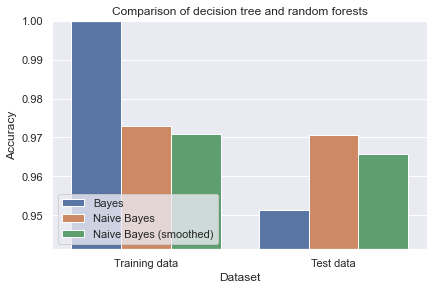

In [13]:
result_df = pd.DataFrame(result_df, columns=["Dataset", "Algorithm", "Accuracy", "Kappa"])
display(result_df)
sns.barplot(data=result_df, x="Dataset", y="Accuracy", hue="Algorithm")
plt.ylim((np.min(result_df["Accuracy"]) - 0.01, 1.0))
plt.title("Comparison of decision tree and random forests")
plt.legend(loc="lower left")
plt.tight_layout(pad=.5)
plt.show()

## Interpretation

- Bayes seem to overfit to training data (probably an artifact of the KDE)
- Results are not significant, we would have to repeat the experiment with cross validation and different random_states (--> different train and test sets)

## Possible Extensions


- implement cross validation
- optimize hyperparameters (kernel bandwidth, additive_smoothing)
- investigate cost sensitive classification on this data set